# Import everything here

In [1]:
from data_module import *
from Euler import *

%reload_ext autoreload
%autoreload 2

# Define notebook parameters

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alpha = 1.3
delta_t = 0.5
t_eval = np.arange(0, 5, delta_t)
num_samples_in_trajectory = math.floor(t_eval[-1] / delta_t)

save_location = "./figures/alpha_1,3_"

# Setup Tensorboard

In [3]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6006

Launching TensorBoard...

# Create dataset

In [4]:
dataset = create_dataset(alpha, t_eval, 50)

# Reshape dataset

In [5]:
dataset = reshape_dataset(dataset)

# Split dataset

In [6]:
training_set, validation_set, test_set = split_dataset(dataset, 0.6, 0.2, 0.2)

# Create NN model and define hyper-parameters

In [7]:
hparams = {
    "hidden_layer_1": 512,
    "hidden_layer_2": 512,
    "hidden_layer_3": 512,
    "delta_t": delta_t,
    "batch_size": 8,
    "learning_rate": 1e-3,
    "num_workers": 8,
}

In [8]:
model = Euler(hparams)

# Original Data

In [9]:
t_eval = np.delete(t_eval, -1, 0)

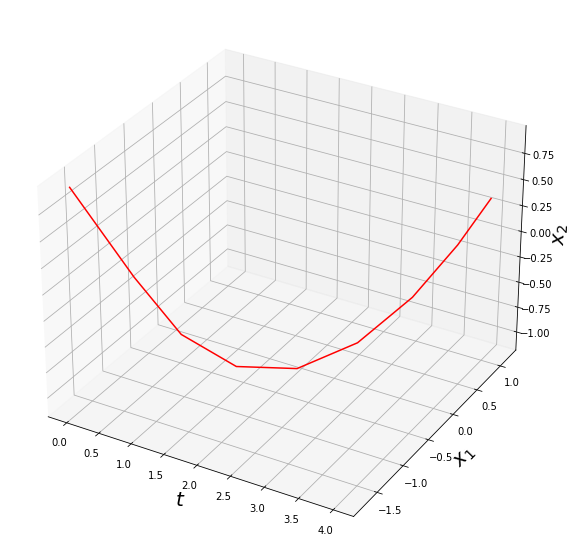

In [10]:
plot_trajectory(validation_set[:num_samples_in_trajectory, 0], t_eval)

# Validation set

Score of the Model before training: 2.626171691166582


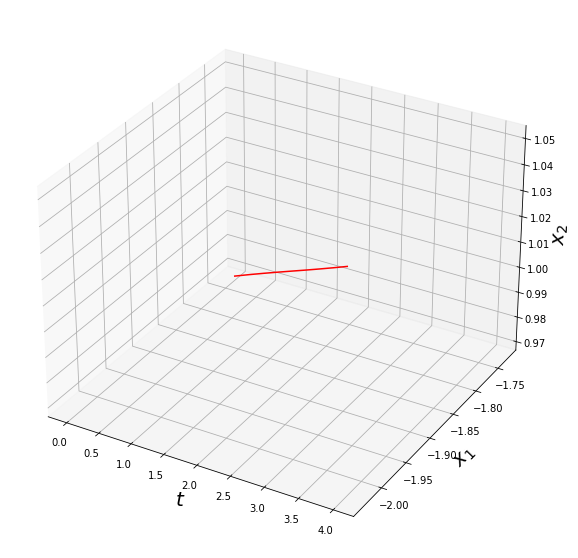

In [11]:
print("Score of the Model before training:", evaluate_model(model, validation_set, hparams, device))
recreation = recreate_trajectory(model, validation_set[0, 0, :], t_eval[0], t_eval[-1], delta_t, device)
plot_trajectory(recreation, t_eval)

In [12]:
train_dataloader = DataLoader(training_set,
                              shuffle=False,
                              batch_size=hparams["batch_size"],
                              num_workers=8)
validation_dataloader = DataLoader(validation_set,
                                    shuffle=False,
                                    batch_size=hparams["batch_size"],
                                    num_workers=8)

In [13]:
trainer = pl.Trainer(
    max_epochs=100,
    log_every_n_steps=5,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 527 K 
-------------------------------------
527 K     Trainable params
0         Non-trainable params
527 K     Total params
2.111     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Score of the Model after training: 3.511896414693486


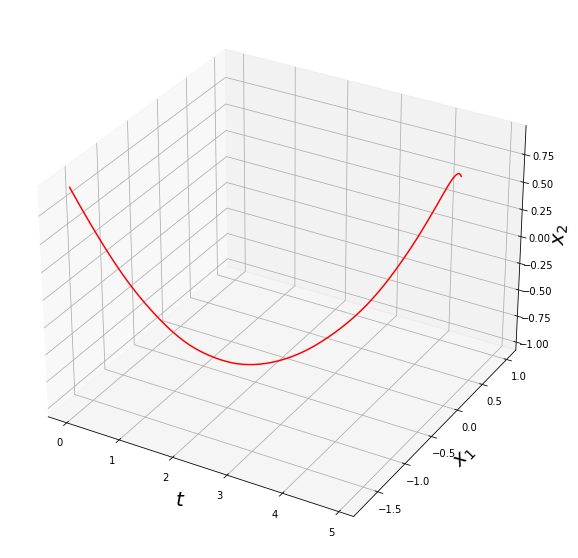

In [21]:
model.hparams["delta_t"] = 0.05
t_eval_tmp = np.arange(0, 5, 0.05).round(2)
t_eval_tmp = np.delete(t_eval_tmp, -1, 0)
print("Score of the Model after training:", evaluate_model(model, validation_set, hparams, device))
recreation = recreate_trajectory(model, validation_set[0, 0, :], t_eval_tmp[0], t_eval_tmp[-1], model.hparams["delta_t"], device)
plot_trajectory(recreation, t_eval_tmp)

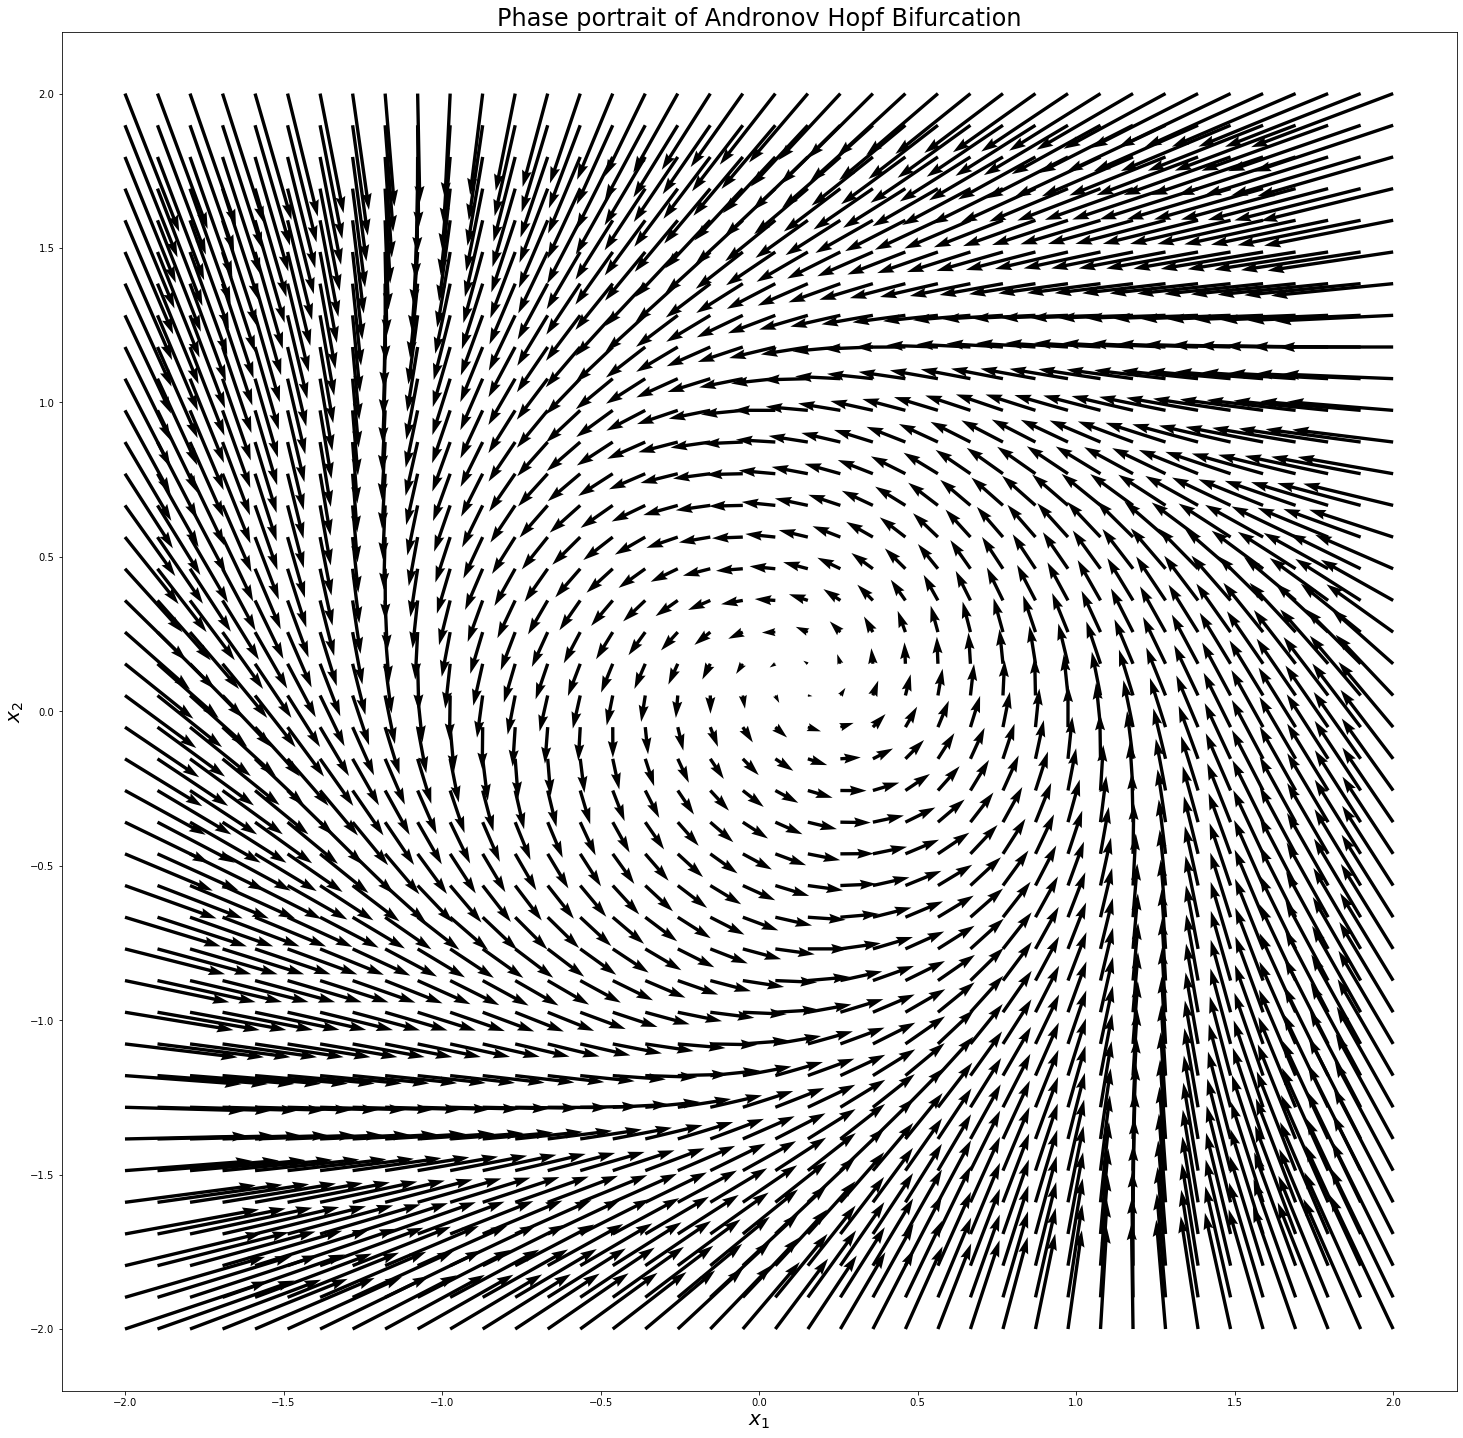

In [22]:
compute_and_plot_phase_portrait(model, 0.05)